In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
rng = np.random.default_rng()

## Define useful functions

In [19]:
def generateX(n):
    x = np.random.randn(n)
    return(x)

def generateNonlinearY(x, sigma):
    n = len(x)
    eps1 = rng.gamma(2, 2, n) - 4
    # eps1 = rng.standard_t(df=3, size=n)
    eps2 = rng.normal(0, .5, n)
    
    y = 2*np.maximum(x, 0) + sigma * ( (x + .5) * eps1 + eps2)
    return y

def splitData(x, y, n1):
    x1 = x[:n1]
    y1 = y[:n1]
    x2 = x[n1:]
    y2 = y[n1:]
    return x1, y1, x2, y2


## Define CQR interval function and residual interval function

In [3]:
# scores on holdout data, Q_alpha/2(x), Q_{1-alpha/2}(x)
def CQRInterval(scores, y_out_l_pred, y_out_u_pred, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    y_out_l = y_out_l_pred - t
    y_out_u = y_out_u_pred + t 
    return np.hstack([y_out_l.reshape(-1, 1), y_out_u.reshape(-1, 1)])

# score = |Y-mu(x)|/sd(x)
def conformalResidueInterval(scores, mu, sigma, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    y_out_l = mu - t*sigma
    y_out_u = mu + t*sigma
    return np.hstack([y_out_l.reshape(-1, 1), y_out_u.reshape(-1, 1)])

## Define neural network for quantile regression and heteroskedastic regression

In [4]:
class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2a = nn.Linear(hidden_dim, 1)
        self.layer2b = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        out1 = self.layer2a(x).squeeze()
        out2 = self.layer2b(x).squeeze()
        return out1, out2 # this outputs estimates of Q_alpha and Q_(1-alpha/2)
    
    
def quantileLoss(y_out_l, y_out_u, y, alpha):
    # this is the row alpha function for both alpha/2 and (1-alpha/2)

    lower_loss = torch.max( (alpha/2)*(y - y_out_l), (alpha/2-1)*(y - y_out_l) )
    upper_loss = torch.max( (1-alpha/2)*(y - y_out_u), (-alpha/2)*(y - y_out_u) )
    return torch.mean(lower_loss + upper_loss)

def heteroskedLoss(mu, log_nu, y):
    return torch.mean( (y - mu)**2 / (2*torch.exp(log_nu)**2) + log_nu )


## Experiment parameters

In [20]:
n = 2000
ntrain = 500

sigma = .2
alpha = 0.05 # 95% prediction interval for Y_new

# Experiment 1

### Generate same data and train neural network for heteroskedastic regression

In [21]:
x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

train_data = TensorDataset(x_train1, y_train1)
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

model = NNet(1, 20)
lr = 0.1
epochs = 150
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):

    epoch_loss = 0
    
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        mu, log_nu = model(x_batch)
        loss = heteroskedLoss(mu, log_nu, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


    if epoch % 20 == 0:
        print('epoch', epoch, 'loss', f"{epoch_loss:.3}")


epoch 0 loss 12.0
epoch 20 loss -2.6
epoch 40 loss -2.36
epoch 60 loss -5.38
epoch 80 loss -3.36
epoch 100 loss -3.71
epoch 120 loss -5.45
epoch 140 loss -4.36


In [23]:
## compute non-conformity scores on second half of training data
## and prediction intervals on test data
x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)

mu_2, log_nu_2 = model(x_train2)
mu_2 = mu_2.detach().numpy()
log_nu_2 = log_nu_2.detach().numpy()    
nu_2 = np.exp(log_nu_2)

scores = np.abs(ytrain2 - mu_2)/nu_2
##np.maximum(ytrain2 - y_out_u2, y_out_l2 - ytrain2)

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
mu_pred, log_nu_pred = model(x_test)
mu_pred = mu_pred.detach().numpy()
log_nu_pred = log_nu_pred.detach().numpy()
nu_pred = np.exp(log_nu_pred)

intervals = conformalResidueInterval(scores, mu_pred, nu_pred, alpha)
# mu_pred +/- s_hat * nu_pred, where s_hat is the (1-alpha)*(n+1)/n quantile of scores

In [24]:
s_hat = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
s_hat # this is very far from the normal quantile 1.96, which is expected given that data is not normal

2.6316759600048063

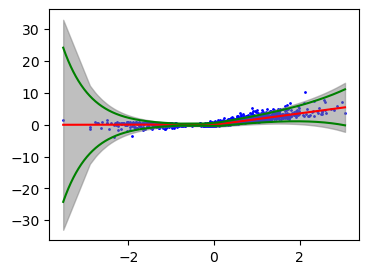

In [25]:
## plot f
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]

xlinspace = np.linspace(xgrid.min(), xgrid.max(), 1000)
xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
mean_linspace, logvar_linspace = model(xlinspace_torch)
mean_linspace = mean_linspace.squeeze().detach().numpy()
sd_linspace = np.exp(logvar_linspace.squeeze().detach().numpy())

plt.figure(figsize=(4, 3))

plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.plot(xlinspace, mean_linspace, 'r-')
plt.plot(xlinspace, mean_linspace + 1.96 * sd_linspace, 'g-')
plt.plot(xlinspace, mean_linspace - 1.96 * sd_linspace, 'g-')

plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

# plt.title('Conformal prediction with studentized residuals ' r'$(\widehat{{s}} = {:.2f})$'.format(s_hat))

In [26]:
cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.9493333333333334


# Experiment 2

### Generate data and train neural network for quantile regression

In [27]:
x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

train_data = TensorDataset(x_train1, y_train1)
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

model = NNet(1, 10)
lr = 0.1
epochs = 150
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):

    epoch_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_out_l, y_out_u = model(x_batch)
        loss = quantileLoss(y_out_l, y_out_u, y_batch, alpha)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 20 == 0:
        print('epoch', epoch, 'loss', f"{epoch_loss:.3}")


epoch 0 loss 9.08
epoch 20 loss 1.12
epoch 40 loss 0.939
epoch 60 loss 0.821
epoch 80 loss 0.769
epoch 100 loss 0.705
epoch 120 loss 0.683
epoch 140 loss 0.684


### Create CQR intervals

In [28]:
## compute non-conformity scores on second half of training data
## and prediction intervals on test data

x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)

y_out_l2, y_out_u2 = model(x_train2)
y_out_l2 = y_out_l2.detach().numpy()
y_out_u2 = y_out_u2.detach().numpy()

scores = np.maximum(ytrain2 - y_out_u2, y_out_l2 - ytrain2)
# CQR scores max(y-Qalpha/2, Q1-alpha/2 - y)

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
y_out_l_pred, y_out_u_pred = model(x_test)
y_out_l_pred = y_out_l_pred.detach().numpy()
y_out_u_pred = y_out_u_pred.detach().numpy()

intervals = CQRInterval(scores, y_out_l_pred, y_out_u_pred, alpha)
# s_hat = (1-alpha)*(n+1)/n quantile of scores
# output: y_out_l_pred - s_hat, y_out_u_pred + s_hat


In [29]:
s_hat = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
s_hat

0.1086025067299507

Text(0.5, 1.0, 'Conformal quantile prediction $(\\widehat{s} = 0.11)$')

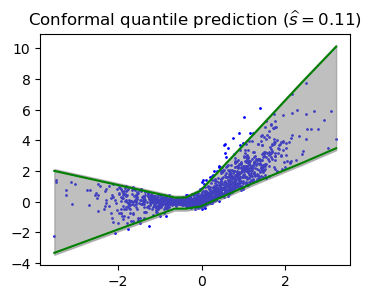

In [30]:
## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

xlinspace = np.linspace(xgrid.min(), xgrid.max(), 1000)
xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
lower, upper = model(xlinspace_torch)
lower = lower.squeeze().detach().numpy()
upper = upper.squeeze().detach().numpy()

plt.figure(figsize=(4, 3))

plt.plot(xlinspace, lower, 'g-')
plt.plot(xlinspace, upper, 'g-')

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')
plt.title('Conformal quantile prediction ' r'$(\widehat{{s}} = {:.2f})$'.format(s_hat))

In [15]:
# checking empirical coverage
cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.9593333333333334


([], [])

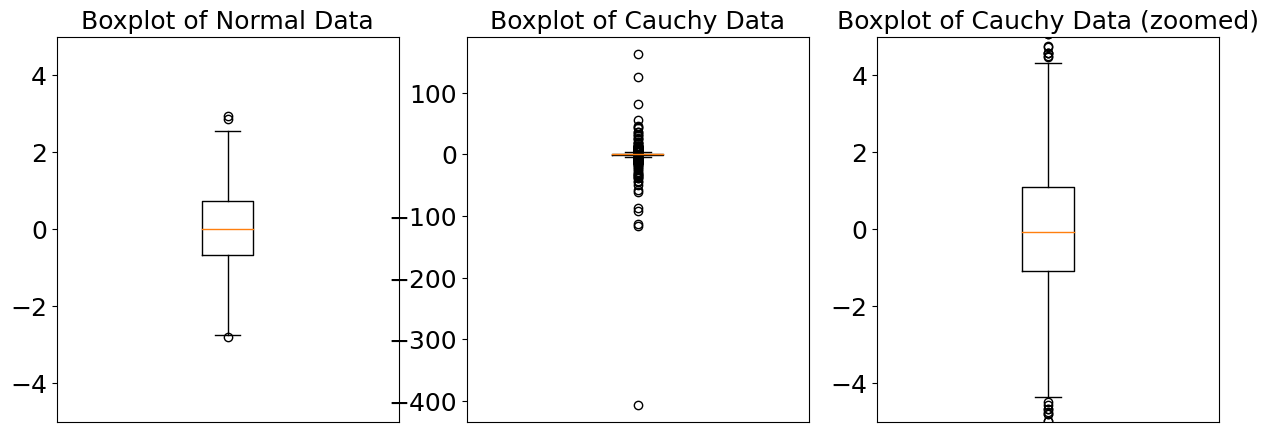

In [16]:
## generate cauchy data and plot boxplot

n = 1000
z = np.random.standard_cauchy(n)
x = np.random.normal(size=n)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.boxplot(x)
plt.title('Boxplot of Normal Data', fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-5, 5)
plt.xticks([])

plt.subplot(1,3,2)

plt.boxplot(z)
plt.title('Boxplot of Cauchy Data', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([])

plt.subplot(1,3,3)

plt.boxplot(z)
plt.title('Boxplot of Cauchy Data (zoomed)', fontsize=18)
plt.ylim(-5, 5)
plt.yticks(fontsize=18)
plt.xticks([])



#plt.tight_layout()
#plt.show()


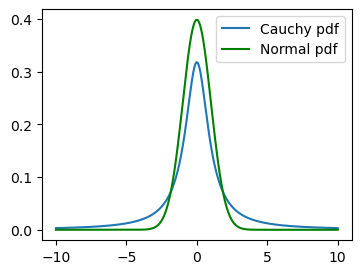

In [17]:
plt.figure(figsize=(4,3))

xgrid = np.linspace(-10, 10, 1000)

cauchy_pdf = stats.cauchy.pdf(xgrid)
normal_pdf = stats.norm.pdf(xgrid)

plt.plot(xgrid, cauchy_pdf, label='Cauchy pdf')
plt.plot(xgrid, normal_pdf, color = 'green', label = 'Normal pdf')
plt.legend()